# IST 718: Big Data Analytics

- Professor: Daniel Acuna <deacuna@syr.edu>

## General instructions:

- You are welcome to discuss the problems with your classmates but __you are not allowed to copy any part of your answers either from your classmates or from the internet__
- You can put the homework files anywhere you want in your http://notebook.acuna.io workspace but _do not change_ the file names. The TAs and the professor use these names to grade your homework.
- Remove or comment out code that contains `raise NotImplementedError`. This is mainly to make the `assert` statement fail if nothing is submitted.
- The tests shown in some cells (i.e., `assert` and `np.testing.` statements) are used to grade your answers. **However, the professor and TAs will use __additional__ test for your answer. Think about cases where your code should run even if it passess all the tests you see.**
- Before downloading and submitting your work through Blackboard, remember to save and press `Validate` (or go to 
`Kernel`$\rightarrow$`Restart and Run All`). 
- Good luck!

In [1]:
# Load the packages needed for this part
# create spark and sparkcontext objects
from pyspark.sql import SparkSession
import numpy as np

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

import pyspark
from pyspark.ml import feature, regression, Pipeline
from pyspark.sql import functions as fn, Row
from pyspark import sql

import matplotlib.pyplot as plt
import pandas as pd

# Part 1: Servo analysis

In this assignment, you will continue the analysis we started in class of the Servo dataset.

# Servo data analysis

```console
1. Title: Servo Data

2. Sources
   (a) Created by: Karl Ulrich (MIT) in 1986
   (b) Donor: Ross Quinlan
   (c) Date: May 1993

3. Past Usage:

   1.  Quinlan, J.R., "Learning with continuous classes", Proc. 5th Australian
       Joint Conference on AI (eds A. Adams and L. Sterling), Singapore: World
       Scientific, 1992
 
   2.  Quinlan, J.R., "Combining instance-based and model-based learning",
       Proc. ML'93 (ed P.E. Utgoff), San Mateo: Morgan Kaufmann 1993
 
       Results on 10-way cross-validation:
 
       Method			Average		Relative
       ------			 |Err|		 Error
 				-------		--------
 
       Guessing mean		  1.15		  1.00
       Instance-based		   .52		   .26
       Regression		   .86		   .49
       Model trees		   .45		   .29
       Neural nets (G. Hinton)	   .30		   .11
       Regression+instances	   .48		   .20
       Model trees+instances	   .30		   .17
       NN+instances		   .29		   .11
 
4. Relevant Information:

   Ross Quinlan:

   This data was given to me by Karl Ulrich at MIT in 1986.  I didn't 
   record his description at the time, but here's his subsequent (1992) 
   recollection:
 
     "I seem to remember that the data was from a simulation of a servo
     system involving a servo amplifier, a motor, a lead screw/nut, and a
     sliding carriage of some sort.  It may have been on of the
     translational axes of a robot on the 9th floor of the AI lab.  In any
     case, the output value is almost certainly a rise time, or the time
     required for the system to respond to a step change in a position set
     point."
 
   (Quinlan, ML'93)

   "This is an interesting collection of data provided by Karl 
    Ulrich.  It covers an extremely non-linear phenomenon - predicting the 
    rise time of a servomechanism in terms of two (continuous) gain settings
    and two (discrete) choices of mechanical linkages."

5. Number of Instances: 167

6. Number of Attributes: 4 + numeric class attribute

7. Attribute information:

   1. motor: A,B,C,D,E
   2. screw: A,B,C,D,E
   3. pgain: 3,4,5,6
   4. vgain: 1,2,3,4,5
   5. class: 0.13 to 7.10

8. Missing Attribute Values: None
```

In [2]:
# Load the data
servo_df = spark.createDataFrame(pd.read_csv('/datasets/servo.data', 
            sep=',', 
            header=None,
            names=['motor', 'screw', 'pgain', 'vgain', 'rise_time']))

# 1. Explore the data

With big data, datasets can be too big to bring them into the Spark client. However, we can use the `limit` method of a dataframe to limit the number of rows to bring as a Pandas dataframe

Create a dataframe `servo_sample_df` with the first 20 rows of `servo_df`

In [3]:
# create `servo_sample_df`
# YOUR CODE HERE
#Making sample dataframe that has first 20 rows from the main dataframe:
servo_sample_df=servo_df.limit(20)
#raise NotImplementedError()

In [4]:
# 2 pts - right number of rows
np.testing.assert_equal(servo_sample_df.count(), 20)

**(3 pts)** Below, transform `servo_sample_df` into a Pandas dataframe and do a scatter plot of `pgain` vs `rise_time`

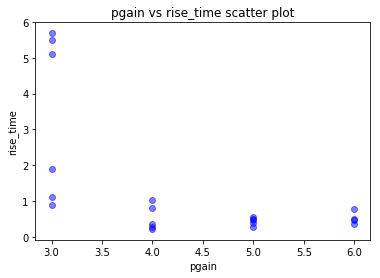

In [5]:
# YOUR CODE HERE
import seaborn as sns

#Using pandas dataframe with matplotplib
servo_sample_pd_df=servo_sample_df.toPandas()

#Tried some seaborn, gives the same output:
#plot_1=sns.scatterplot(x="pgain",y="rise_time",data=servo_sample_pd_df)

#Making a scatterplot using scatter function from matplotlib:
plt.figure()
#x=pgain, y=rise_time, my dot color will be blue and they'd have some transparency due to alpha being 0.5:
plt.scatter(servo_sample_pd_df.pgain,servo_sample_pd_df.rise_time,c="blue",alpha=0.5)
#Just renaming the x and y axes:
plt.xlabel("pgain")
plt.ylabel("rise_time")
#Giving it a title:
plt.title("pgain vs rise_time scatter plot")
display()
#raise NotImplementedError()

**(3 pts)** Below, transform `servo_sample_df` into a Pandas dataframe and do a scatter plot of `vgain` vs `rise_time`

  motor screw  pgain  vgain  rise_time
0     E     E      5      4   0.281251
1     B     D      6      5   0.506252
2     D     D      4      3   0.356251
3     B     A      3      2   5.500033
4     D     B      6      5   0.356251


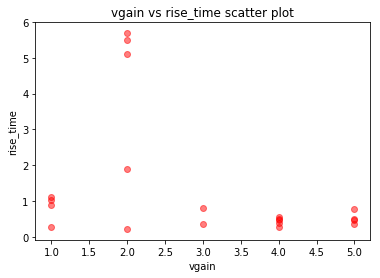

In [6]:
# YOUR CODE HERE
#Same as before, pandas to be used with matplotlib:
servo_sample_pd_df=servo_sample_df.toPandas()
#Printing the first 5 rows of dataframe to check:
print(servo_sample_pd_df.head())
#plot_2=sns.scatterplot(x="vgain",y="rise_time",data=servo_sample_pd_df)

#Same as previous block: Just changed the dot color to red
plt.figure()
plt.scatter(servo_sample_pd_df.vgain,servo_sample_pd_df.rise_time,c="red",alpha=0.5)
plt.xlabel("vgain")
plt.ylabel("rise_time")
plt.title("vgain vs rise_time scatter plot")
display()
#raise NotImplementedError()

## Perform correlations between vgain-rise time, pgain-rise time, and vgain-pgain

Create a `servo_corr_df` dataframe that contains the correlations between `vgain` and `rise_time` as a column `corr_vgain_rise_time`, between `pgain` and `rise_time` as `corr_pgain_rise_time`, and `vgain` and `pgain` as `corr_vgain_pgain`.

In [7]:
# create `servo_corr_df` here
# YOUR CODE HERE

#Taking the dataframe as pandas dataframe:
servo_pd_df=servo_df.toPandas()

#Calculating individual correlations and assigning them to variables:
corr_vgain_rise_time=servo_pd_df["vgain"].corr(servo_pd_df["rise_time"])
corr_pgain_rise_time=servo_pd_df["pgain"].corr(servo_pd_df["rise_time"])
corr_vgain_pgain=servo_pd_df["vgain"].corr(servo_pd_df["pgain"])

#Making a pandas dataframe from the variables and giving appropriate names to the columns. Using print to check my results:
servo_corr_pd_df=pd.DataFrame([[corr_vgain_rise_time,corr_pgain_rise_time,corr_vgain_pgain]],columns=["corr_vgain_rise_time","corr_pgain_rise_time","corr_vgain_pgain"])
#print(servo_corr_pd_df.head())

#Converting the same pandas dataframe to Spark dataframe, checking the result using print:
servo_corr_df=spark.createDataFrame(servo_corr_pd_df)
print(servo_corr_df.first())

#raise NotImplementedError()

   corr_vgain_rise_time  corr_pgain_rise_time  corr_vgain_pgain
0             -0.364383             -0.598129          0.812268
Row(corr_vgain_rise_time=-0.36438266626914606, corr_pgain_rise_time=-0.5981287119612234, corr_vgain_pgain=0.812268305818388)


In [8]:
## 7 pts
np.testing.assert_equal(set(servo_corr_df.columns), 
                        {'corr_pgain_rise_time', 'corr_vgain_pgain', 'corr_vgain_rise_time'})
np.testing.assert_almost_equal(list(servo_corr_df.first().asDict().values()),
                               [-0.36438266626914595, -0.5981287119612234, 0.8122683058183874], decimal=3)

## Compute mean rise_time for different motors and screws

Create `motor_rise_time_df` with the column `motor` and `avg_rise_time`, where `avg_rise_time` is the average rise time for a motor. Sort the resulting dataframe from highest to lowest average rise time.

In [83]:
# YOUR CODE HERE

#Doing somewhat same steps here for calculating mean. Using pandas dataframe. Calcuating group wise means for the 5 different types of motors and putting them ina pandas dataframe:
servo_pd_df=servo_df.toPandas()
motor_rise_time_pd_df=servo_pd_df.groupby("motor")["rise_time"].mean().reset_index()
motor_rise_time_pd_df=motor_rise_time_pd_df.rename(columns=({"rise_time":"avg_rise_time"}))
motor_rise_time_pd_df=motor_rise_time_pd_df.sort_values(by="avg_rise_time",ascending=False)
#print(motor_rise_time_pd_df.head())

#Converting the pandas dataframe to a Spark dataframe:
motor_rise_time_df=spark.createDataFrame(motor_rise_time_pd_df)

#raise NotImplementedError()

  motor  avg_rise_time
0     A       1.761111
1     B       1.681942
2     C       1.254061
4     E       1.144893
3     D       0.917613


In [10]:
# 3 pts
np.testing.assert_array_almost_equal(
    (motor_rise_time_df.orderBy('motor').select('avg_rise_time').\
     rdd.map(lambda x: list(x.asDict().values())).collect())
    ,
[[1.761110668888889],
 [1.6819423677777776],
 [1.2540610067499998],
 [0.9176125145454546],
 [1.144893208181818]], decimal=3)

Create `screw_rise_time_df` with the column `screw` and `avg_rise_time` sorted from highest to lowest average rise time.

In [74]:
# YOUR CODE HERE

#Same as the steps used in calculating mean for motors, usinf pandas as calculating groupwise means for 5 different types of screws, storing them in pandas dataframe:
servo_pd_df=servo_df.toPandas()
screw_rise_time_pd_df=servo_pd_df.groupby("screw")["rise_time"].mean().reset_index()
screw_rise_time_pd_df=screw_rise_time_pd_df.rename(columns=({"rise_time":"avg_rise_time"}))
screw_rise_time_pd_df=screw_rise_time_pd_df.sort_values(by="avg_rise_time",ascending=False)
#print(screw_rise_time_pd_df.head())

#Eventually converting them to Spark Dataframe:
screw_rise_time_df=spark.createDataFrame(screw_rise_time_pd_df)

#raise NotImplementedError()

In [12]:
# 3 pts
np.testing.assert_array_almost_equal(
    (screw_rise_time_df.orderBy('screw').select('avg_rise_time').\
     rdd.map(lambda x: list(x.asDict().values())).collect())
    ,
       [[1.768461212142857],
 [1.3919625091428571],
 [1.2485862280645161],
 [1.1612471173333332],
 [1.225643291724138]],
decimal=3)

# Feature engineering

## Dummy variables for motors and screws
Create a dataframe `dummy_df` with columns `motor` and `screw` as dummy variables, and columns `vgain`, `pgain`, and `rise_time`. Use motor D and screw C as the baselines and name the dummy variables `motor_A` for motor `A` and so on. Follow a similar pattern for screw. The dataframe `dummy_df` should not contain the columns `motor` and `screw` but only their dummy variable representations. **All column types should be float or integer.**

In [13]:
# create dummy_df below
# YOUR CODE HERE

#Making dummy_df from servo_df with the first motor_A column for motors of type A (motor_A=1 for motor type A, else it'd be 0):
dummy_df=servo_df.withColumn("motor_A",fn.when(fn.col("motor")=="A",1).otherwise(0))

#Now just overwriting dummy_df with an additional columns for motor type B (column motor_B will be 1 if motor is B else 0):
dummy_df=dummy_df.withColumn("motor_B",fn.when(fn.col("motor")=="B",1).otherwise(0))

#motor_C column will be 1 for motor type C:
dummy_df=dummy_df.withColumn("motor_C",fn.when(fn.col("motor")=="C",1).otherwise(0))

#motor_E will be 1 for motor type E, else it'd be 0:
dummy_df=dummy_df.withColumn("motor_E",fn.when(fn.col("motor")=="E",1).otherwise(0))

#Motor type D is baseline; meaning if all the dummy columns for different motor types are 0, motor type defaults to being D.

#Same thing for screw types, here screw_A will be 1 if screw if os type A, else will be 0:
dummy_df=dummy_df.withColumn("screw_A",fn.when(fn.col("screw")=="A",1).otherwise(0))

#screw_B will be 1 if screw is of type B, else it will be 0:
dummy_df=dummy_df.withColumn("screw_B",fn.when(fn.col("screw")=="B",1).otherwise(0))

#screw_D will be 1 if screw is of type D, else it will be 0:
dummy_df=dummy_df.withColumn("screw_D",fn.when(fn.col("screw")=="D",1).otherwise(0))

#screw_E will be 1 if screw is of type E, else it will be 0:
dummy_df=dummy_df.withColumn("screw_E",fn.when(fn.col("screw")=="E",1).otherwise(0))
#Baseline for screws is screw C; meaning if all dummy columns for 4 types of screws are 0 (screw isn't of any of those 4 types), screw will be by default of class C

#Dropping columns 'motor' and 'screw' since we have used dummy to specify the types of motors and screws:
dummy_df=dummy_df.drop("motor")
dummy_df=dummy_df.drop("screw")

#Checking my output:
dummy_df.show(5)

#raise NotImplementedError()

+-----+-----+----------+-------+-------+-------+-------+-------+-------+-------+-------+
|pgain|vgain| rise_time|motor_A|motor_B|motor_C|motor_E|screw_A|screw_B|screw_D|screw_E|
+-----+-----+----------+-------+-------+-------+-------+-------+-------+-------+-------+
|    5|    4|0.28125095|      0|      0|      0|      1|      0|      0|      0|      1|
|    6|    5| 0.5062525|      0|      1|      0|      0|      0|      0|      1|      0|
|    4|    3|0.35625148|      0|      0|      0|      0|      0|      0|      1|      0|
|    3|    2|  5.500033|      0|      1|      0|      0|      1|      0|      0|      0|
|    6|    5|0.35625148|      0|      0|      0|      0|      0|      1|      0|      0|
+-----+-----+----------+-------+-------+-------+-------+-------+-------+-------+-------+
only showing top 5 rows



In [14]:
# 3 pts
np.testing.assert_equal(len(dummy_df.columns), 11)
np.testing.assert_equal(dummy_df.select(fn.sum('motor_A')).first()['sum(motor_A)'], 36)
np.testing.assert_equal(dummy_df.select(fn.sum('screw_A')).first()['sum(screw_A)'], 42)

# Model comparison

In the next set of questions, you will use the splits below to fit, validate, and estimate the generalization error of your models. The `randomSplit` is called with a seed so that it does not change from what the professor used.

In [15]:
training_df, validation_df, testing_df = dummy_df.randomSplit([0.6, 0.3, 0.1], seed=0)
print("# points in training: ", training_df.count())
print("# points in validation: ", validation_df.count())
print("# points in testing: ", testing_df.count())

# points in training:  102
# points in validation:  50
# points in testing:  15


## Propose three regression models

In the next section, you will choose the best model to explain the data in `servo_df`. Select the right split of the data for the right step of the process (i.e., training, validation, and testing)

### Model 1: Fit model with only `pgain`

Create a pipeline that takes *pgain* as a feature to predict *rise time* and fits a linear regression model. You should start your pipeline by taking the appropriate column or columns from `dummy_df` in which the raw feature `pgain` may or may not have been feature engineered. Assign the fit pipeline transformer to `pipe_model1`. Your pipeline must have one vector assembler followed by a linear regression.

In [16]:
training_df

DataFrame[pgain: bigint, vgain: bigint, rise_time: double, motor_A: int, motor_B: int, motor_C: int, motor_E: int, screw_A: int, screw_B: int, screw_D: int, screw_E: int]

In [35]:
# create `pipe_model1` below
# YOUR CODE HERE
#Making pipeline for the first model of linear regression with only pgain. The model has a vector assembler to change pgain to features and a linear regression estimator:
pl1=Pipeline(stages=[feature.VectorAssembler(inputCols=["pgain"],outputCol="features"),regression.LinearRegression(featuresCol="features",labelCol="rise_time")])

#Fitting the pipeline (which is an estimator) with training_df to get a model (or transformer):
pipe_model1=pl1.fit(training_df)

#raise NotImplementedError()

In [18]:
# (5 pts)
np.testing.assert_equal(type(pipe_model1.stages[0]), feature.VectorAssembler)
np.testing.assert_equal(type(pipe_model1.stages[1]), regression.LinearRegressionModel)
np.testing.assert_array_equal(pipe_model1.stages[1].coefficients.shape, (1,))

### Model 2: Fit model with only `vgain`

Follow the same idea as above and create a pipeline transformer `pipe_model2`

In [19]:
# YOUR CODE HERE

#Doing the same as above, except that the input for linear regression is now vgain:
pl2=Pipeline(stages=[feature.VectorAssembler(inputCols=["vgain"],outputCol="features"),regression.LinearRegression(featuresCol="features",labelCol="rise_time")])
pipe_model2=pl2.fit(training_df)

#raise NotImplementedError()

In [20]:
# (5 pts)
np.testing.assert_equal(type(pipe_model2.stages[0]), feature.VectorAssembler)
np.testing.assert_equal(type(pipe_model2.stages[1]), regression.LinearRegressionModel)
np.testing.assert_array_equal(pipe_model2.stages[1].coefficients.shape, (1,))

### Model 3: Fit model with only motor, screw, pgain, and vgain

Follow the same idea as above and create a pipeline transformer `pipe_model3`. Remember that some features have been feature engineered. In particular, use the transformed columns in the order: motor, screw, pgain, and vgain. Choose the columns from `dummy_df` appropriately.

In [21]:
# create `pipe_model2` below
# YOUR CODE HERE

#Same as previous 2 pipelines, except that now we are using all the columns as input (all columns from the dataframe dummy_df):
pl3=Pipeline(stages=[feature.VectorAssembler(inputCols=["motor_A","motor_B","motor_C","motor_E","screw_A","screw_B","screw_D","screw_E","pgain","vgain"],outputCol="features"),regression.LinearRegression(featuresCol="features",labelCol="rise_time")])
pipe_model3=pl3.fit(training_df)

#raise NotImplementedError()

In [22]:
# (5 pts)
np.testing.assert_equal(type(pipe_model3.stages[0]), feature.VectorAssembler)
np.testing.assert_equal(type(pipe_model3.stages[1]), regression.LinearRegressionModel)
np.testing.assert_array_equal(pipe_model3.stages[1].coefficients.shape, (10,))

# Compare models

### Estimate RMSE on validation data for the three models

Create three dataframes `rmse1_df`, `rmse2_df`, and `rmse3_df` for models 1, 2, and 3, respectively, with only with column `rmse`

In [87]:
# create rmse1_df, rmse2_df, and rmse3_df dataframes below
# YOUR CODE HERE
#Writing a function to calculate RMSE by subtracting actual rise_time from predicted rise time by the model, squaring it, taking mean of squared error terms and taking root of that mean:
rmse = fn.sqrt(fn.mean((fn.col('rise_time') - fn.col('prediction'))**2)).alias('rmse')

#Calculating the RMSE for all 3 of my models using the validation dataframe (from the 3 transformers created from 3 pipelines) and saving them to dataframes:
rmse1_df=pipe_model1.transform(validation_df).select(rmse)
rmse2_df=pipe_model2.transform(validation_df).select(rmse)
rmse3_df=pipe_model3.transform(validation_df).select(rmse)

#Tried changing the names from simple 'rmse' to RMSE for individual models using alis, but the assertion cases are using 'rmse' as column names, so kept it the same
#raise NotImplementedError()

In [88]:
# display the answers here
#Displaying the RMSE dataframes for the 3 models:
rmse1_df.show()
rmse2_df.show()
rmse3_df.show()

+----------------+
|            rmse|
+----------------+
|1.34327577005387|
+----------------+

+-----------------+
|             rmse|
+-----------------+
|1.514903147547569|
+-----------------+

+------------------+
|              rmse|
+------------------+
|1.3529798940782019|
+------------------+



In [89]:
# (5 pts)
np.testing.assert_equal(rmse1_df.count(), 1)
np.testing.assert_equal(rmse2_df.count(), 1)
np.testing.assert_equal(rmse3_df.count(), 1)
np.testing.assert_equal(rmse1_df.columns, ['rmse'])
np.testing.assert_equal(rmse2_df.columns, ['rmse'])
np.testing.assert_equal(rmse3_df.columns, ['rmse'])

Assign the best cross validated model to a variable `best_model` below

In [26]:
# assign best model (the best pipeline transformer) to a variable best_model below
# YOUR CODE HERE

#Based on the RMSE values, the model generated from pipeline 1 is the best cross validated one (Since the RMSE for that one was the lowest among the 3 models; 1.34327577005387)
best_model=pipe_model1

#raise NotImplementedError()

In [27]:
# (2 pts)
np.testing.assert_equal(type(best_model), pyspark.ml.pipeline.PipelineModel)

### Estimate generalization performance with RMSE

Create a variable `rmse_best_df` that contains the RMSE of the best model on testing data

In [28]:
# create rmse_best_df
# YOUR CODE HERE

#I am calculating the rmse (using the previously defined function to calculate rmse) of my best model (from 1st pipeline's transformer (pipe_model1)) 
#on training data. It is important to use training_df now for I wanna see the generalization performance:
rmse_best_df=pipe_model1.transform(testing_df).select(rmse)

#raise NotImplementedError()

In [29]:
# (3 pts)
np.testing.assert_equal(rmse_best_df.count(), 1)
np.testing.assert_equal(rmse_best_df.columns, ['rmse'])

**(3 pts)** What is the best estimated generalization performance of the best model? Answer in the cell below

In [30]:
# YOUR CODE HERE

#Showing the rmse dataframe
rmse_best_df.show()

#raise NotImplementedError()

+------------------+
|              rmse|
+------------------+
|1.1120589909789866|
+------------------+



# Do inference with best model

Assume that model 3 is the best one. Redefine a new pipeline for this model called `pipe_model_best` and fit it to the **entire training data** (all of `dummy_df`).

In [52]:
# create `pipe_model_best` below
# YOUR CODE HERE

#As mentioned in the statement, taking model 3's pipeline for it was deemed to be the best model:
pipe_best=pl3

#Making the model from this pipeline using all the data avaialable to us. The data has been feature engineered to dummy variables for classes:  
pipe_model_best=pipe_best.fit(dummy_df)

#raise NotImplementedError()

In [53]:
# (4 pts) check that the model was fitted correctly
np.testing.assert_equal(type(pipe_model_best.stages[0]), feature.VectorAssembler)
np.testing.assert_equal(type(pipe_model_best.stages[1]), regression.LinearRegressionModel)
np.testing.assert_array_equal(pipe_model_best.stages[1].coefficients.shape, (10,))

**(4 pts)** Assume that all features on `dummy_df` were comparable (i.e., standardized). Taking motor D and screw C as the baseline, what are the top 2 most important features for *increasing rise time* and the top 2 most important features for *decreasing rise time*? Answer below with code and comments to support your answer

In [82]:
# YOUR CODE HERE

#Making the variable list. I copied the list from my inputCol list for the pipeline 3 (pl3) because the order of variables is that:
var_list=["motor_A","motor_B","motor_C","motor_E","screw_A","screw_B","screw_D","screw_E","pgain","vgain"]

#Getting the coefficients from the model I made in the previous code block, getting it into a list:
coeff_list=list(pipe_model_best.stages[1].coefficients)

#Using zip function on these 2 lists to make a dictionary of variables and parameters:
para_dic=dict(zip(var_list,coeff_list))
#print(para_dic)
#print(coeff_list)
#print(var_list)

#most_pos=dict(sorted(para_dic.items(),key=operator.itemgetter(1),reverse=False))

#Sorting the dictionary based on the coefficient values in ascending order
sort_dic=dict(sorted(para_dic.items(),key=lambda ele: ele[1]))

#print(sort_dic)

#making alist of keys from the dictionary (basically list of all variables):
d_keys=list(sort_dic.keys())
#print(type(d_keys))

#Printing the last 2 keys and values from the sorted dictionary, thus having highest coefficient values:
print("Top 2 factors in increasing rise time: 1).",list(sort_dic.keys())[-1],":",list(sort_dic.values())[-1]," 2).",list(sort_dic.keys())[-2],":",list(sort_dic.values())[-2])

#Printing first 2 keys and values from the sorted dictionary, thus having the lowest coefficient values:
print("Top 2 factors in decreasing rise time: 1).",list(sort_dic.keys())[0],":",list(sort_dic.values())[0]," 2).",list(sort_dic.keys())[1],":",list(sort_dic.values())[1])

#raise NotImplementedError()

Top 2 factors in increasing rise time: 1). motor_A : 1.430299448895454  2). motor_B : 1.3511311477843428
Top 2 factors in decreasing rise time: 1). pgain : -1.6435283526061615  2). screw_D : -0.12295757537582756
